### Pixel segmentation of digitized books 

---

This notebook builds on the CAMVID example of pixel segmentation with an example from a GLAM setting.


[Open in colab](https://colab.research.google.com/drive/1DbiF49vJUCqD0thOof-seO7HLTCwDxS5?usp=sharing)

If running in Google colab you might need to install some things. 

First we install fastai in Colab. I had some issues with getting an earlier version of fastai so I specify it must be at least version 2.0. This is probably not necessary though. 

In [1]:
!pip install -q fastai==2.0

     |████████████████████████████████| 358kB 2.8MB/s 


Imports are the same as in the fastai notebook example, the only additional import is tqdm which is a library which gives you easy access to progress bars.

In [2]:
from fastai.vision.all import *
from tqdm.notebook import tqdm

Optionally you can also install nbdev which will give you prettier documentation of fastai functions and methods. 

In [3]:
!pip install -q nbdev

     |████████████████████████████████| 61kB 2.0MB/s 


### The Data 

Finding pixel level segmentation open (data) with a GLAM focus wasn't that easy. Although document segmentation/layout recogntion is a big area of work see for example [Prima lab](https://www.primaresearch.org/datasets), [ICDAR competions](https://zenodo.org/record/3568023), these are usually annotated with bounding boxes or line annotations as opposed to pixel masks like we saw in CAMVID. 

I did find one dataset associated with the [dh_segment tool](https://github.com/dhlab-epfl/dhSegment). This dataset contains pixel masks for digitsed books. We can download the data from their GitHub page using wget. If you are using colab wget will quickly become your best friend  😜 

In [4]:
!wget -q https://github.com/dhlab-epfl/dhSegment/releases/download/v0.2/pages.zip
!unzip -q pages.zip

If you are using Colab the data will disapear when your instance times out. This isn't such a problem in this example because the data is small enough to download on the fly but if you are working with larger datasets you may want to mount a google drive folder to persist data. 

Let's take a look at the data. The code in fastai often makes use of Pathlib (which is where `Path` comes from. If you learned Python a while ago you might be more used to the `os` module. I think pathlib is often much nicer to work with so it might be worth checking it out. There is a nice tutorial introducing it on [Real Python](https://realpython.com/python-pathlib/) (as an aside, Real Python is a great website. The quality of the tutorials/articles usually seems to be really good). 

In [5]:
path = Path('pages/')
path.ls()

(#4) [Path('pages/train'),Path('pages/val_a1'),Path('pages/test_a1'),Path('pages/classes.txt')]

We have various folders for training, validation and testing, and a classes.txt file. We can create a shortcut to our training labels and images:

In [6]:
path_lbl = path/'train/labels'
path_img = path/'train/images'

fastai includes a lot of handy utility functions to do things which you often need to do in deep learning. One of these is `get_image_files()`. We can use `doc()` to get more info on what this does:

In [7]:
doc(get_image_files)

Because I installed nbdev I also get a url link to to the documentation website. 

We can grab the urls for all the image files in the label folder

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[5]

Path('pages/train/labels/unibas_IMG_MAX_309366.png')

Taking a look at one example label image. 

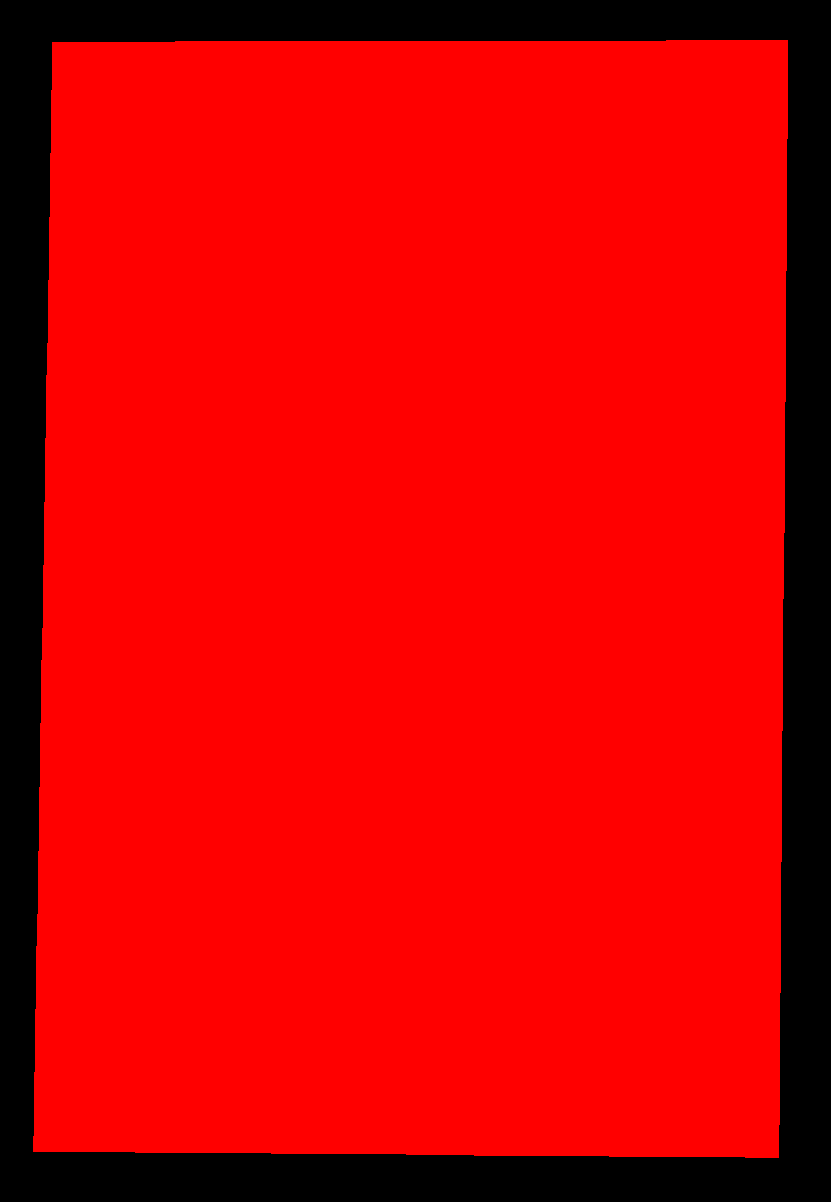

In [9]:
PILImage.create(lbl_names[5])

This looks like a 'mask'. It will be useful to also see the original image this mask is for. 

In [10]:
img_names = get_image_files(path_img)

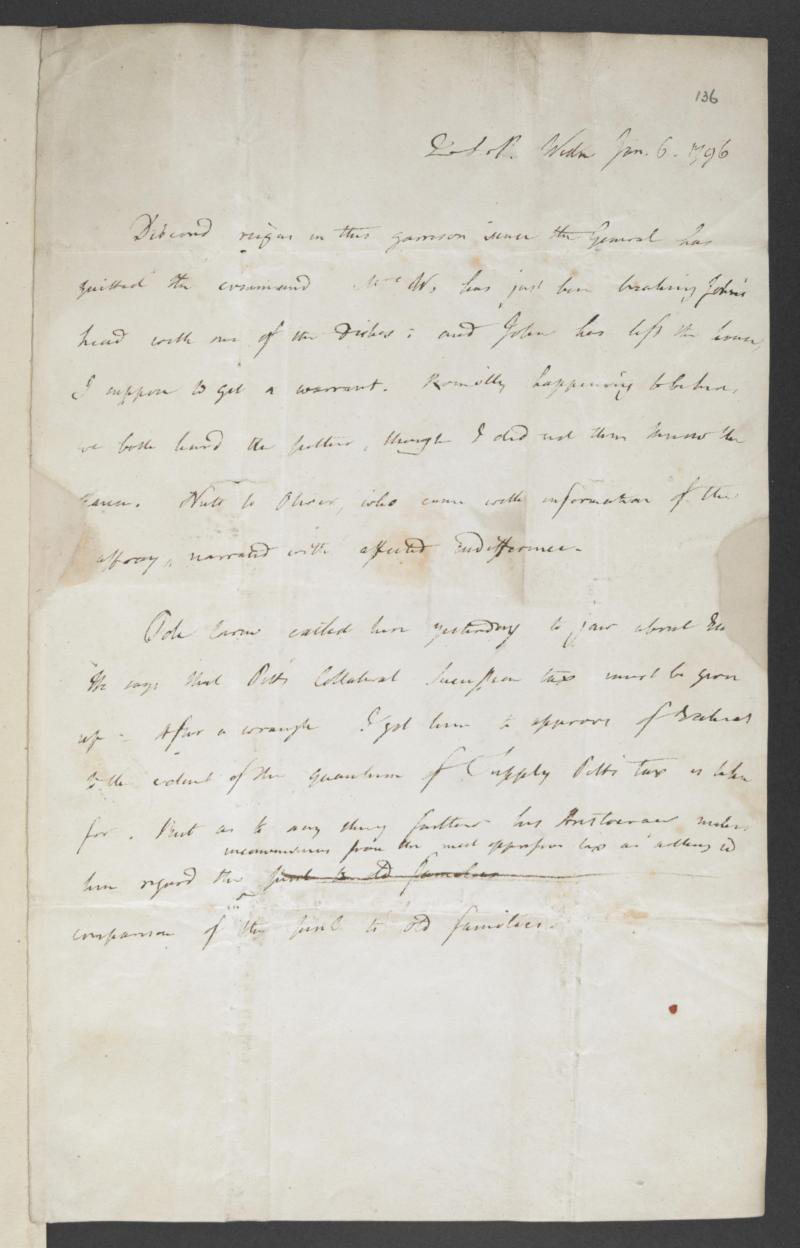

In [11]:
PILImage.create(img_names[5])

We can see that this mask crops out the borders of the digisted text to crop to the page proper. 

I ran into a few issues with getting this data to load and train succesfully using the exact approach in the CAMVID notebook so had to do a few additional steps. I found some suggestions in a forum thread: https://forums.fast.ai/t/dealing-with-cuda-device-assist-on-segmentation-and-other-segmentation-issues-some-tips-a-wiki/64363/9 which links to a notebook, I borrowed the code from this notebook which seemed to have solved my issues. 

This function gets the unique "codes" from the mask i.e. the RGB values which are used to encode different pixel labels. 

In [12]:
def n_codes(fnames):
  "Gather the codes from a list of `fnames`"
  vals = set()
  for fname in tqdm(fnames):
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [13]:
vals = n_codes(lbl_names)
vals

{0: 0, 1: 76}

This `get_msk` function defines how the masks are created when we load the data,  we'll use this later. 

In [14]:
def get_msk(x, pix2class):
  fn =  f"{x.parent.parent}/labels/{x.stem}.png"
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(pix2class):
    msk[msk==pix2class[i]] = val
  return PILMask.create(msk)

We create a simple lambda function which calls get msk and the code dictionary we created above. This has the purpse of mapping the orginal RGB value to a new values mapping. 

In [15]:
get_y = lambda o: get_msk(o, vals)

In this example we use the `DataBlock` api to load our data. This is something which will be covered much more later on the course, so I'll skirt over this in this notebook. 

In [16]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock()),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [17]:
dls = binary.dataloaders(path/'train/images', bs=8)

Now we have the data loaded, lets make the `show_batch()`

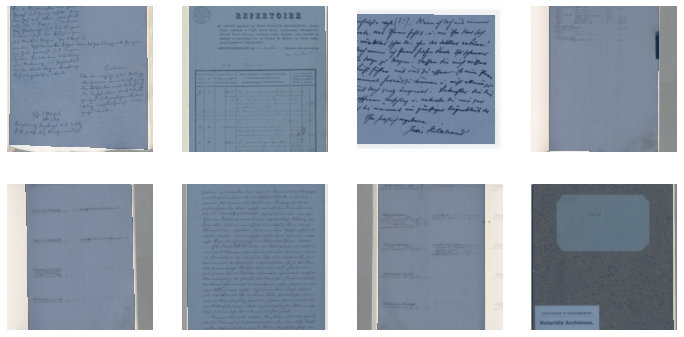

In [18]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1)


the next steps are almost the same as in camvid example. We specify the number of outputs since we didn't pass in the codes when we loaded the data. These two labels are either "mask" or "no mask". We also add a metric to track `Dice` which is a fairly common pixel segmentation metric. 

In [19]:
learn = unet_learner(dls, resnet34, n_out=2, metrics=[Dice()])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [20]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,dice,time
0,0.303906,0.180065,0.953951,00:55


epoch,train_loss,valid_loss,dice,time
0,0.114224,0.075414,0.984904,00:54
1,0.081172,0.057612,0.988947,00:54
2,0.083094,0.053019,0.989128,00:54
3,0.059307,0.045512,0.990445,00:53
4,0.051095,0.050931,0.988919,00:53
5,0.037229,0.046048,0.990548,00:53
6,0.032897,0.046431,0.990814,00:53
7,0.029628,0.045303,0.991012,00:54


We can use `show_results()` to show a few predictions:

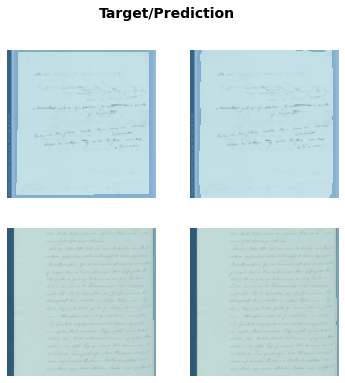

In [21]:
learn.show_results()

fin